In [33]:
import math
import numpy as np

from PIL import Image
from scipy.fft import fft2, ifft2
from scipy.signal import fftconvolve, convolve2d

from skimage import img_as_float, data, restoration, io
from matplotlib import pyplot as plt

In [34]:
### Blurs
def psf_gaussian(dim: tuple, s1: float = 0, s2: float = 0, i: int = 0, j: int = 0) -> np.ndarray:
    '''
    Returns a point spread function using a Gaussian blur.

    Parameters:
        dim (tuple): dimensions of the image to produce, ex. (3,3) for a 3x3 kernel
        s1 (float): scaling factor for dim[0]
        s2 (float): scaling factor for dim[1]
        i (int): offset for center of psf in dim[0]
        j (int): offset for center of psf in dim[1]

    Returns:
        Normalized matrix for Gaussian blur.
    '''

    # verify that kern size is not zero or negative
    if dim[0] < 1 or dim[1] < 1:
        raise ValueError("Dimensions must be greater than or equal to 1.")

    # verify that i and j offsets are in range [0, dim - 1]
    if i < 0 or i >= dim[0] - 1:
        raise ValueError("i must be in range of [0, dim - 1]")
    if j < 0 or j >= dim[1] - 1:
        raise ValueError("j must be in range of [0, dim - 1]")

    # create matrix of zeros
    p = np.zeros(dim)

    # apply blur
    for x in range(0, dim[0]):
        for y in range(0, dim[1]):
            p[x, y] = math.exp(-0.5 * ((x - i)/s1)**2 - 0.5 * ((y - j)/s2)**2)

    # normalize p values to [0, 1]
    # p = p / np.linalg.norm(p)

    return p

def pad_psf(mat: np.ndarray, size: tuple) -> np.ndarray:
    '''
    Pads a point spread funciton with zeros. The original PSF will
    appear in the upper-lerft corner in order to preserve center
    of PSF for future computations.

    Parameters:
        mat (ndarray): matrix to pad
        size (tuple): desired dimensions of the padded matrix

    Returns:
        Matrix containing the padded data.
    '''

    zeros = np.zeros(size)
    zeros[0:mat.shape[0], 0:mat.shape[1]] = mat
    return zeros

def circshift(mat, amt):
    return np.roll(np.roll(mat, amt[0], axis=0), amt[1], axis=1)

def blur_fft(X, P, center):
    # compute eigenvalues
    S = fft2(circshift(P, (0 - center[0], 0 - center[1])))
    # compute blurred image
    B = np.real(ifft2(np.multiply(S, fft2(X))))
    # normalize to values in range [0, 1]
    B = (B - np.min(B))/(np.max(B) - np.min(B)) # normalizes
    return B

### Image utilities
def im_float_to_bmp(mat):
    '''
        Converts floating-point values in a matrix to [0, 255].
        Useful for saving the image.
    '''
    return (mat * 255 / np.max(mat)).astype('uint8')

def load_img(path):
    '''
        Returns a matrix from a given image
    '''
    mat = np.asarray(Image.open(path))
    return mat / 255

def save_img_raw(mat, path):
    '''
        Saves an image to the specified path. Assumes no undoing of boundary conditions.
    '''
    Image.fromarray(im_float_to_bmp(mat)).save(path)

In [35]:
def compute_loss(deconv_im, psf, conv_im):
    return np.sum(fftconvolve(deconv_im, psf, mode='same') - conv_im * np.log(fftconvolve(deconv_im, psf, mode='same')))

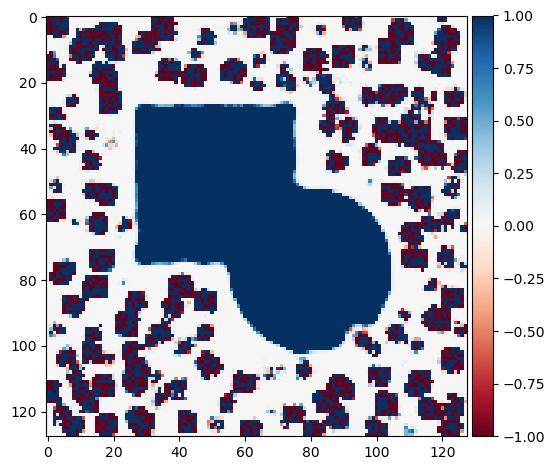

In [36]:
psf_size   = (7, 7)             # dimensions of PSF
psf_fn     = psf_gaussian         # specifies function to generate PSF
s          = 2                    # spread of PSF; s = s1 = s2
img_name   = 'shapes'             # image to use
sample_img = 'samples/{}.png'.format(img_name)
psf_center = tuple(int(i/2) for i in psf_size)

true_image = load_img(sample_img)
psf        = psf_gaussian(psf_size, s, s, psf_center[0], psf_center[1])
psf        = np.where(psf < 1e-2, 0, psf)
save_img_raw(psf, 'results/convex_loss/1_psf.png')

# image  = fftconvolve(true_image, psf, mode='same')
# convolve image with PSF
image_conv = convolve2d(true_image, psf, mode='same')
save_img_raw(image_conv, 'results/convex_loss/2_image_conv.png')

# add noise
rng = np.random.default_rng()
image_conv += 0.1 * image_conv.std() * rng.standard_normal(image_conv.shape)

# regularization parameter to help with divide by zero errors
eps = 1e-12
filter_eps = 1e-2
clip = True

num_iter = 100
im_deconv = image_conv
psf_mirror = np.flip(psf)
for _ in range(num_iter):
    conv = convolve2d(im_deconv, psf, mode='same') + eps
    if filter_eps:
        relative_blur = np.where(conv < filter_eps, 0, image_conv / conv)
    else:
        relative_blur = image_conv / conv
    im_deconv *= convolve2d(relative_blur, psf_mirror, mode='same')

if clip:
    im_deconv[im_deconv > 1] = 1
    im_deconv[im_deconv < -1] = -1

io.imshow(im_deconv)
plt.show()
save_img_raw(im_deconv, 'results/test.png')